# Lab 7

## Task 1: Image Quality Enhancement, Image Restoration

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10

import tensorflow as tf

import time

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar100

In [2]:
(x_train, _), (x_test, _) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

input_shape = (32, 32, 3)

170498071/170498071 [==============================] - 32s 0us/step


In [3]:
def add_noise_and_blur(images):
    noisy_images = []
    for img in images:
        noisy_img = img + 0.1 * np.random.normal(0, 1, img.shape)
        noisy_img = np.clip(noisy_img, 0, 1)
        blurred_img = cv2.GaussianBlur(noisy_img, (5,5), 0)
        noisy_images.append(blurred_img)
    return np.array(noisy_images)

x_train_noisy = add_noise_and_blur(x_train)
x_test_noisy = add_noise_and_blur(x_test)

def build_autoencoder():
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)
    return model



In [4]:

autoencoder = build_autoencoder()
autoencoder.compile(optimizer=Adam(), loss='mse')

autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=64, validation_data=(x_test_noisy, x_test))

def compute_psnr(original, restored):
    mse = np.mean((original - restored) ** 2)
    return 20 * np.log10(1.0 / np.sqrt(mse)) if mse > 0 else 100  # PSNR formula

predictions = autoencoder.predict(x_test_noisy)

num_images = 5
plt.figure(figsize=(10, 5))

Epoch 1/10
782/782 [==============================] - 7s 6ms/step - loss: 0.0094 - val_loss: 0.0061
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 8/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 9/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 10/10
313/313 [==============================] - 1s 2ms/step


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

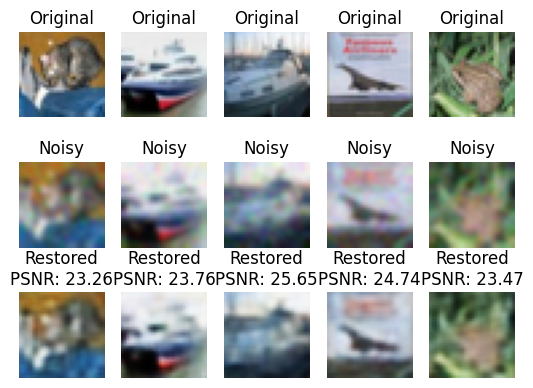

In [5]:
for i in range(num_images):
    plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.title("Original")

    plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(x_test_noisy[i])
    plt.axis('off')
    plt.title("Noisy")

    plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.title(f"Restored\nPSNR: {compute_psnr(x_test[i], predictions[i]):.2f}")

plt.show()


## Task 2: :- Image Classification using AlexNet and VGG16

In [6]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

print(f"Train Data: {x_train.shape}, Labels: {y_train.shape}")
print(f"Test Data: {x_test.shape}, Labels: {y_test.shape}")


169001437/169001437 [==============================] - 40s 0us/step
Train Data: (50000, 32, 32, 3), Labels: (50000, 100)
Test Data: (10000, 32, 32, 3), Labels: (10000, 100)


In [7]:
def build_alexnet(input_shape, num_classes):
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),  # Define Input Layer

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),  # Avoid reducing feature map to 0

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

alexnet = build_alexnet((32, 32, 3), 100)
alexnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
alexnet.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 256)         5

In [8]:
base_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

for layer in base_vgg16.layers:
    layer.trainable = False

vgg16 = Sequential([
    base_vgg16,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='softmax')
])

vgg16.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
vgg16.summary()


58889256/58889256 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               51300     
                                                                 
Total params: 15,028,644
Trainable params: 313,956
Non-trainable params: 14,714,688
_____________________________________

In [9]:
epochs = 10
batch_size = 64

start_time = time.time()
alexnet_history = alexnet.fit(x_train, y_train, validation_data=(x_test, y_test),
                              epochs=epochs, batch_size=batch_size)
alexnet_time = time.time() - start_time
print(f"AlexNet Training Time: {alexnet_time:.2f} sec")

start_time = time.time()
vgg16_history = vgg16.fit(x_train, y_train, validation_data=(x_test, y_test),
                           epochs=epochs, batch_size=batch_size)
vgg16_time = time.time() - start_time
print(f"VGG16 Training Time: {vgg16_time:.2f} sec")


Epoch 1/10
782/782 [==============================] - 7s 8ms/step - loss: 4.2881 - accuracy: 0.0353 - val_loss: 3.9592 - val_accuracy: 0.0830
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 3.8288 - accuracy: 0.0999 - val_loss: 3.4895 - val_accuracy: 0.1602
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 3.4854 - accuracy: 0.1572 - val_loss: 3.2321 - val_accuracy: 0.2084
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 3.2626 - accuracy: 0.1990 - val_loss: 3.0319 - val_accuracy: 0.2521
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 3.0868 - accuracy: 0.2310 - val_loss: 2.9078 - val_accuracy: 0.2786
Epoch 6/10
782/782 [==============================] - 7s 9ms/step - loss: 2.9291 - accuracy: 0.2624 - val_loss: 2.8083 - val_accuracy: 0.2921
Epoch 7/10
782/782 [==============================] - 6s 8ms/step - loss: 2.7957 - accuracy: 0.2883 - val_loss: 2.7365 - val_accuracy: 0.3131
Epoch 

In [10]:
alexnet_eval = alexnet.evaluate(x_test, y_test, verbose=0)
vgg16_eval = vgg16.evaluate(x_test, y_test, verbose=0)

print(f"AlexNet Test Accuracy: {alexnet_eval[1]:.4f}, Loss: {alexnet_eval[0]:.4f}")
print(f"VGG16 Test Accuracy: {vgg16_eval[1]:.4f}, Loss: {vgg16_eval[0]:.4f}")


AlexNet Test Accuracy: 0.3561, Loss: 2.5634
VGG16 Test Accuracy: 0.3654, Loss: 2.4870


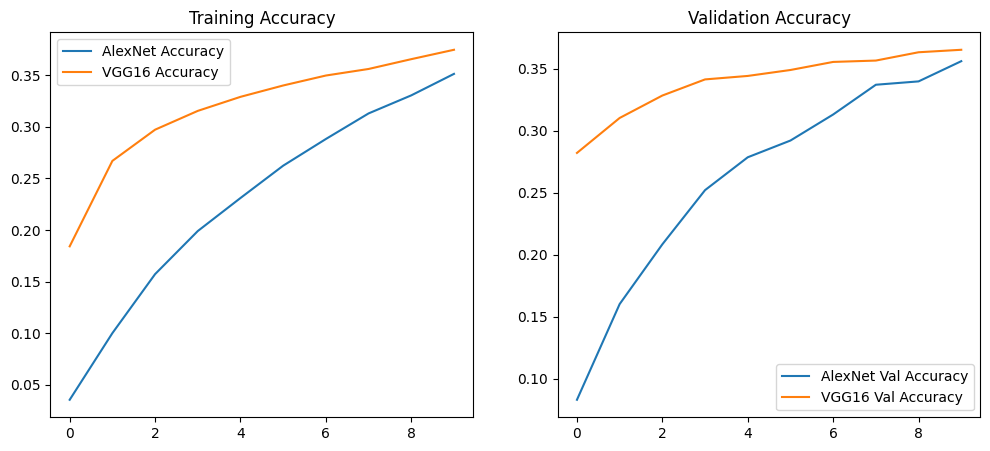

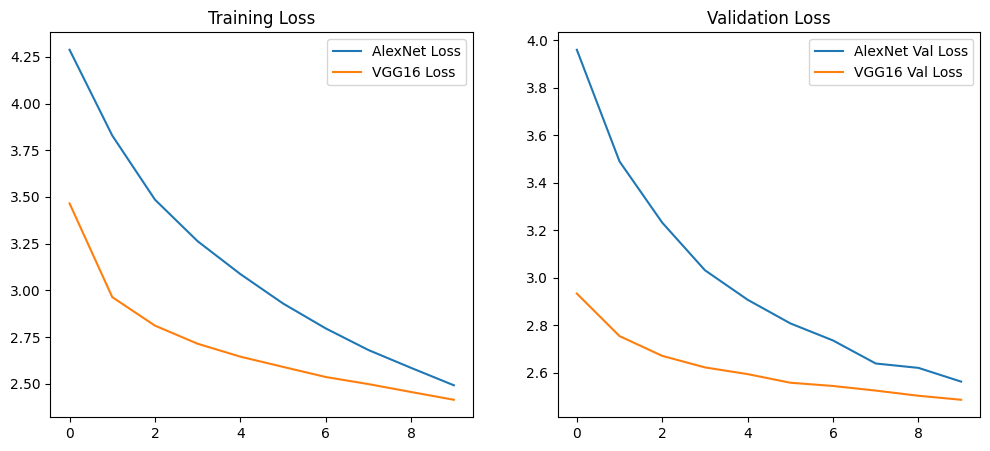

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(alexnet_history.history['accuracy'], label="AlexNet Accuracy")
plt.plot(vgg16_history.history['accuracy'], label="VGG16 Accuracy")
plt.legend()
plt.title("Training Accuracy")

plt.subplot(1, 2, 2)
plt.plot(alexnet_history.history['val_accuracy'], label="AlexNet Val Accuracy")
plt.plot(vgg16_history.history['val_accuracy'], label="VGG16 Val Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(alexnet_history.history['loss'], label="AlexNet Loss")
plt.plot(vgg16_history.history['loss'], label="VGG16 Loss")
plt.legend()
plt.title("Training Loss")

plt.subplot(1, 2, 2)
plt.plot(alexnet_history.history['val_loss'], label="AlexNet Val Loss")
plt.plot(vgg16_history.history['val_loss'], label="VGG16 Val Loss")
plt.legend()
plt.title("Validation Loss")

plt.show()


In [13]:
print(f"Model\t\t| Test Accuracy\t| Test Loss\t| Training Time")
print("-" * 80)
print(f"AlexNet\t\t| {alexnet_eval[1]:.4f}\t\t| {alexnet_eval[0]:.4f}\t\t| {alexnet_time:.2f} sec")
print(f"VGG16\t\t| {vgg16_eval[1]:.4f}\t\t| {vgg16_eval[0]:.4f}\t\t| {vgg16_time:.2f} sec")


Model		| Test Accuracy	| Test Loss	| Training Time
--------------------------------------------------------------------------------
AlexNet		| 0.3561		| 2.5634		| 67.31 sec
VGG16		| 0.3654		| 2.4870		| 87.75 sec
